In [1]:
import math
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt
from matplotlib import cm 
from matplotlib.colors import from_levels_and_colors
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
def abline(slope, intercept, ax):
    """Coordenadas en funcion de ordenada al origen y pendiente"""
    x_vals = np.array(ax.get_xlim())
    return (x_vals, intercept + slope * x_vals)



<Axes: xlabel='Peso', ylabel='Altura'>

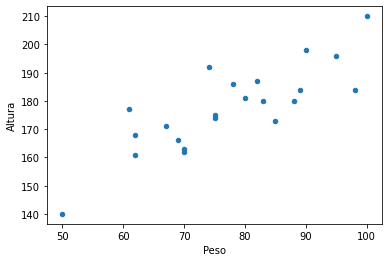

In [3]:
data = {
    'Peso':   [50, 62,  88,  74,  67,  80, 98,   78,  82,  75,  75,  70,  95,  69,  83,  62,  90,  61,  70,  89,  85, 100],
    'Altura': [140,161, 180, 192, 171, 181, 184, 186, 187, 175, 174, 162, 196, 166, 180, 168, 198, 177, 163, 184, 173, 210]
}

# Crear el DataFrame
df = pd.DataFrame(data)
df[['Peso', 'Altura']].plot.scatter(x='Peso', y='Altura')

Fuga de datos detectada, pero es un ejemplo de juguete con pocos datos para dividir en entrenamiento y test

In [5]:
#Escalo peso y altura para simplificar el grafico
df_scaled = pd.DataFrame(StandardScaler().fit_transform(df[['Peso', 'Altura']]),columns=['Peso', 'Altura'])

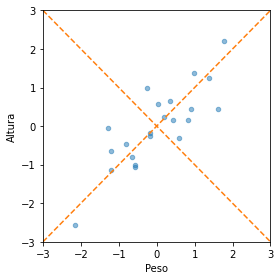

In [6]:

pcs = PCA(n_components=2)
pcs.fit(df_scaled)
loadings = pd.DataFrame(pcs.components_, columns=df.columns)

ax = df_scaled.plot.scatter(x='Peso', y='Altura', alpha=0.5, figsize=(4, 4))
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.plot(*abline(loadings.loc[0, 'Altura'] / loadings.loc[0, 'Peso'], 0, ax),'--', color='C1')
ax.plot(*abline(loadings.loc[1, 'Altura'] / loadings.loc[1, 'Peso'], 0, ax),'--', color='C1')

plt.tight_layout()
plt.show()



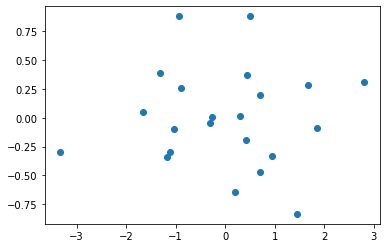

In [7]:
X_pca = pcs.transform(df_scaled)
plt.scatter(X_pca[:,0], X_pca[:,1])

In [8]:
df_var = pd.DataFrame(pcs.explained_variance_ratio_, columns=["var_exp"])
df_var["PC"] = np.arange(1, pcs.n_components_+1,1)


In [9]:
df_var


,var_exp,PC
0,0.910852,1
1,0.089148,2


<BarContainer object of 2 artists>

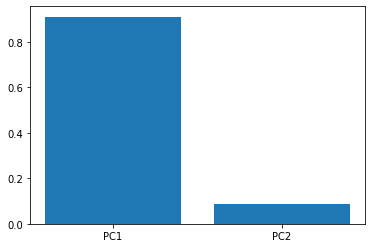

In [10]:
plt.bar(["PC1", "PC2"], df_var["var_exp"], label=["PC1", "PC2"])

Ejemplo mas pequeño que nos permita dar seguimiento a la transformación

In [11]:
data = {
    'id':[1,2,3,4,5,6],
    'VAL1': [10,11,8,3,1,2],
    'VAL2': [6,4,5,3,2.8,1]
}
df = pd.DataFrame(data)


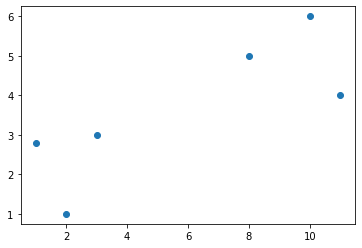

In [12]:
plt.scatter(df["VAL1"], df["VAL2"])
plt.show()

In [13]:
pcs = PCA(n_components=2) #Si le pongo 1 me retorna solo el primer componente principal
pcs.fit(df.loc[:, ["VAL1", "VAL2"]])
df.loc[:, ["tv1", "tv2"]] = pcs.transform(df.loc[:, ["VAL1", "VAL2"]])
df_loads = pd.DataFrame(pcs.components_, columns=df.loc[:,["VAL1", "VAL2"]].columns)


In [13]:
df_loads

,VAL1,VAL2
0,0.946299,0.323293
1,0.323293,-0.946299


In [14]:
pcs.explained_variance_ratio_

array([0.95321878, 0.04678122])

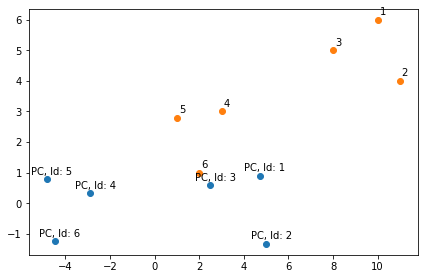

In [15]:
plt.scatter(df["tv1"], df["tv2"])
plt.scatter(df["VAL1"], df["VAL2"])
for i in range(len(df)):
    plt.annotate("PC, Id: "+str(df['id'][i]), (df['tv1'][i], df['tv2'][i]), textcoords="offset points", xytext=(5,5), ha='center')

for i in range(len(df)):
    plt.annotate(df['id'][i], (df['VAL1'][i], df['VAL2'][i]), textcoords="offset points", xytext=(5,5), ha='center')

#x = np.linspace(0, 20, 20)
#y = df_loads.loc[0, ["VAL2"]].values[0] * x + 0
#plt.plot(x, y)
plt.tight_layout()
plt.show()

In [16]:
df[["id","VAL1","tv1"]]

,id,VAL1,tv1
0,1,10,4.708039
1,2,11,5.007751
2,3,8,2.492148
3,4,3,-2.885932
4,5,1,-4.843189
5,6,2,-4.478818


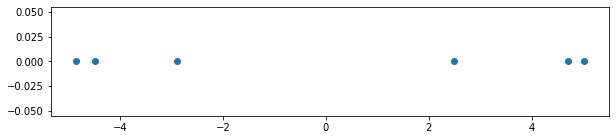

In [17]:
plt.figure(figsize=(10,2))
plt.scatter(df.loc[:,["tv1"]], np.zeros(len(df)))
ax.set_ylim(-0.1, 0.1)
plt.show()

Para evitar la fuga de datos, al igual que con imputadores, escaladores es necesario hacer el ajuste con los datos de entrenamiento y la transformacion / imputacion tanto a entrenamiento como a test

In [18]:
from sklearn.model_selection import train_test_split


data = {
    'Peso':   [50, 62,  88,  74,  67,  80, 98,   78,  82,  75,  75,  70,  95,  69,  83,  62,  90,  61,  70,  89,  85, 100],
    'Altura': [140,161, 180, 192, 171, 181, 184, 186, 187, 175, 174, 162, 196, 166, 180, 168, 198, 177, 163, 184, 173, 210],
    'target':[0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,1,1,1,1,1,1,0]
}

# Crear el DataFrame
df = pd.DataFrame(data)
X_train, X_test, y_train, y_test = train_test_split(df[df.columns.drop('target')], df["target"], test_size=0.3)

In [19]:
pcs = PCA(n_components=1)
pcs.fit(X_train)
X_train.loc[:, "PA"] = pcs.transform(X_train)
X_test.loc[:, "PA"] = pcs.transform(X_test)


In [21]:
from sklearn.base import BaseEstimator, TransformerMixin
class PCAWC(BaseEstimator, TransformerMixin):
    def __init__(self, pca=PCA(n_components=1), columns=[], out_columns=[]):
        super().__init__()
        self.pca        = pca 
        self.columns    = columns
        self.out_columns = out_columns

       
    def fit(self, X, y=None):
        self.pca.fit(X[self.columns])
        return self
    
    def get_feature_names_out(self):
        return self.out_columns
    
    def  transform(self, X):
        Xc = X.copy()
        Xc.loc[:, self.get_feature_names_out()] = self.pca.transform(X[self.columns])
        Xc = Xc.drop(columns=self.columns)
        return Xc

In [22]:
# Crear el DataFrame
df = pd.DataFrame(data)
X_train, X_test, y_train, y_test = train_test_split(df[df.columns.drop('target')], df["target"], test_size=0.3, random_state=42)
pca = PCAWC(pca=PCA(n_components=1), columns=["Peso", "Altura"], out_columns=["PA"])
pca.fit(X_train)
pca.transform(X_train)

,PA
11,-22.266725
3,2.811281
4,-17.533972
17,-17.036563
12,19.753889
18,-21.519384
16,17.926372
2,3.145344
9,-9.229085
21,33.538871


---